In [129]:
import os
import filecmp
import h5py
import numpy as np
import matplotlib.pyplot as plt
from math import isnan

In [130]:
DATASET_PATH = '/home/elliot/Desktop/cnn_denoising_dataset'
# I combined e.g. `train_01` and `train_02` into `train`
# `train_road` is all unlabeled, probably it's meant to be augmented
SETS = ['test', 'train', 'val']
#  0: no label, 100: valid/clear, 101: rain, 102: fog
LABEL_NAMES = {0: 'no label', 100: 'clear', 101: 'rain', 102: 'fog'}

# Investigate Sample File

In [131]:
sample_file = os.path.join(DATASET_PATH, 'test', '2018-11-29_114626_Static2-Day-Clear', 'LidarImage_000000607.hdf5')
sample_file = h5py.File(sample_file, 'r')
sample_file.keys()

<KeysViewHDF5 ['distance_m_1', 'intensity_1', 'labels_1', 'sensorX_1', 'sensorY_1', 'sensorZ_1']>

In [132]:
sample_file['distance_m_1'], sample_file['intensity_1'], sample_file['labels_1']

(<HDF5 dataset "distance_m_1": shape (32, 400), type "<f4">,
 <HDF5 dataset "intensity_1": shape (32, 400), type "<f4">,
 <HDF5 dataset "labels_1": shape (32, 400), type "<i4">)

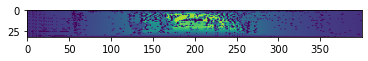

In [133]:
plt.imshow(sample_file['distance_m_1'])

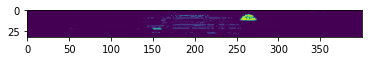

In [134]:
plt.imshow(sample_file['intensity_1'])

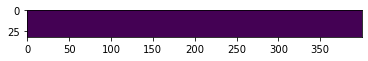

In [135]:
plt.imshow(sample_file['labels_1'])

(array([    0.,     0., 12800.,     0.]),
 array([ 99.5 ,  99.75, 100.  , 100.25, 100.5 ]),
 <a list of 4 Patch objects>)

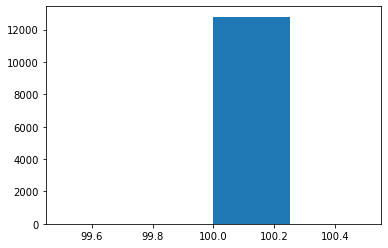

In [136]:
# The sample file is all 'clear'
plt.hist(sample_file['labels_1'][()].flatten(), bins=4)

# Count Samples

"In total, the data set contains about 175,941 samples for
training, validation and testing containing chamber (72,800)
and road (103,141) scenes, which can be used thanks to
augmentation"

Our counts are less, since we haven't done augmentation (yet)

In [137]:
# Count samples in each training set
set_counts = {set_name: 0 for set_name in SETS}
for set_name in set_counts:
    for root, dirs, files in os.walk(os.path.join(DATASET_PATH, set_name)):
        set_counts[set_name] += len(files)
total_samples = sum(count for name, count in set_counts.items())
print(f'Total samples: {total_samples}')
for name, count in set_counts.items():
    print(f'{name}: {(count / total_samples * 100):.2f}%')
# The total above from the original paper probably includes augmented samples

Total samples: 72800
test: 27.18%
train: 47.36%
val: 25.46%


In [138]:
# Number of samples that are majority `label`, skipping 0/no label
sample_counts = {label: 0 for label in LABEL_NAMES.keys() if label != 0}
# Total number of points labeled with `label`
label_counts = {label: 0 for label in LABEL_NAMES.keys() if label != 0}
# Samples that have any adverse weather at all (rain or fog)
adverse_samples = {label: 0 for label in LABEL_NAMES.keys() if label != 0}
for set_name in SETS:
    for root, dirs, files in os.walk(os.path.join(DATASET_PATH, set_name)):
        for file in files:
            file = h5py.File(os.path.join(root, file), 'r')
            labels = file['labels_1'][()].flatten()
            labels, counts = np.unique(labels, return_counts=True)
            counts = {label: count for label, count in zip(labels, counts)}
            
            # Remove where label == 0 (0 = no label)
            if 0 in counts:
                del counts[0]

            dominant_label = max(counts, key=counts.get)
            sample_counts[dominant_label] += 1

            for label, count in counts.items():
                label_counts[label] += count

            # Count any adverse weather: 101 = rain, 102 = fog
            # Note that a sample could have both rain and fog
            if 101 in counts or 102 in counts:
                if 101 in counts:
                    adverse_samples[101] += 1
                if 102 in counts:
                    adverse_samples[102] += 1
            else:
                adverse_samples[100] += 1
            
    print(set_name, sample_counts, label_counts, adverse_samples)
sample_counts, label_counts, adverse_samples

test {100: 18209, 101: 1578, 102: 0} {100: 165576589, 101: 14434632, 102: 8401398} {100: 5044, 101: 7254, 102: 7489}
train {100: 49786, 101: 3660, 102: 821} {100: 449886989, 101: 36921889, 102: 29827314} {100: 12048, 101: 21177, 102: 21042}
val {100: 67674, 101: 4305, 102: 821} {100: 590595222, 101: 50640285, 102: 39598287} {100: 14386, 101: 28637, 102: 29777}


({100: 67674, 101: 4305, 102: 821},
 {100: 590595222, 101: 50640285, 102: 39598287},
 {100: 14386, 101: 28637, 102: 29777})

In [139]:
assert(sum(sample_counts.values()) == total_samples)
print('Dominant sample labels')
for label, count in sample_counts.items():
    print(f'{LABEL_NAMES[label]}: {(count / total_samples * 100):.2f}%')

total_points = sum(label_counts.values())
print('Labeled points')
for label, count in label_counts.items():
    print(f'{LABEL_NAMES[label]}: {(count / total_points * 100):.2f}%')

# May be more than `total_samples` if some samples have rain and fog
total_adverse_samples = sum(adverse_samples.values())
print('Samples with any adverse weather')
for label, count in adverse_samples.items():
    print(f'{LABEL_NAMES[label]}: {(count / total_adverse_samples * 100):.2f}%')

Dominant sample labels
clear: 92.96%
rain: 5.91%
fog: 1.13%
Labeled points
clear: 86.75%
rain: 7.44%
fog: 5.82%
Samples with any adverse weather
clear: 19.76%
rain: 39.34%
fog: 40.90%


In [ ]:
# Confirming that all `train_road` samples are unlabeled (all labels are 0)...probably meant to be augmented
for root, dirs, files in os.walk(os.path.join(DATASET_PATH, 'train_road')):
    for file in files:
        file_path = os.path.join(root, file)
        file = h5py.File(file_path, 'r')
        labels = file['labels_1'][()].flatten()
        if not np.all(labels == 0):
            print(file_path)
    print(root, 'complete')

# Investigate File Pairs

Some samples are pairs of files, e.g. `[original].hdf5` and `[original]_2.hdf5`. Unclear what this means, see this issue: https://github.com/rheinzler/PointCloudDeNoising/issues/8

In [140]:
file_names = []
for set_name in SETS:
    for root, dirs, files in os.walk(os.path.join(DATASET_PATH, set_name)):
        file_names.extend(os.path.join(root, file) for file in files)
assert len(file_names) == total_samples
pairs = list(filter(lambda f: f.endswith('_2.hdf5'), file_names))
print(f'Pairs found: {len(pairs)}')

Pairs found: 7193


In [141]:
def hdf5_equal(a, b):
    if a.keys() != file2.keys(): return False
    for key in a.keys():
        if not np.all(a[key][()] == file2[key][()]): return False
    if list(a.attrs) != list(file2.attrs): return False
    for attr in file1.attrs:
        aa, ba = file1.attrs[attr], file2.attrs[attr]
        if not aa == ba and not (isnan(aa) and isnan(ba)): return False
    return True

In [142]:
# Runs successfully, files appear to be equal
for file2_path in pairs:
    file1_path = file2_path[:-7] + '.hdf5'
    file1, file2 = h5py.File(file1_path, 'r'), h5py.File(file2_path, 'r')
    assert hdf5_equal(file1, file2), (file1_path, file2_path)

In [143]:
filecmp.cmp(
    os.path.join(DATASET_PATH, 'train', '2018-11-29_145021_Static1-Day-Clear', 'LidarImage_000000010.hdf5'),
    os.path.join(DATASET_PATH, 'train', '2018-11-29_145021_Static1-Day-Clear', 'LidarImage_000000010_2.hdf5'),
    shallow=False
)

False

The contents of each pair (and the data that we'd be using) appear to be equal, but the files do not compare equally...could be some additional metadata that isn't captured by `h5py`?